# Usando Monte Carlo para simular o NPV de modelos

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import collections
from sklearn import datasets, linear_model, model_selection
from scipy import stats

%matplotlib inline
sns.set(
    style="whitegrid",
    palette="colorblind",
    rc={"figure.figsize": (11.7, 8.27)}
)

# gerador de números aleatórios que será usado no Monte Carlo
gen = np.random.default_rng(0)

PertRecord = collections.namedtuple(
    "PertRecord",
    ["pessimist", "base", "optimist"]
)

## Funções

In [2]:
def make_data(**kws):
    X, y = datasets.make_classification(**kws)
    X = pd.DataFrame(X).rename(columns=lambda c: f"x{c:02d}")
    y = pd.Series(y, name="target")
    return X, y

def ks(score, target):
    return stats.ks_2samp(
        score[target.eq(0)],
        score[target.eq(1)]
    ).statistic

def make_model(**kws):
    X, y = make_data(**kws)

    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=0
    )

    m = linear_model.LogisticRegression(penalty="none").fit(X_train, y_train)
    scores = pd.Series(
        m.predict_proba(X_test)[:, 0],
        name="score",
        index=y_test.index
    )
    ks_ = ks(scores, y_test)
    
    return X, y, m, scores, ks_

def bad_rate(score, target, cutoff=0.6, reps=1_000, approval=0.66):
    bad_rates = []
    # cortamos 1-cutoff % dos scores para simular o funil de crédito
    population = score.rank(pct=True).ge(cutoff)
    
    # bootstrap
    for n in range(reps):
        approved = score[population].sample(
            frac=approval,
            replace=True,
            random_state=n
        )
        bad_rates.append(target[approved.index].mean())
    
    return pd.Series(bad_rates, name="bad_rate")

def pert(pessimist, base, optimist, gen, *, size=1):
    r = optimist - pessimist
    alpha = 1 + 4 * (base - pessimist) / r
    beta = 1 + 4 * (optimist - base) / r
    return pessimist + gen.beta(alpha, beta, size=size) * r

## Modelos

In [3]:
SPEC = {
    "n_samples": 50_000,
    "n_features": 20,
    "n_informative": 20,
    "n_redundant": 0,
    "flip_y": 0,
    "weights": [1-0.3],
    "random_state": 0
}

In [4]:
X1, y1, m1, scores1, ks1 = make_model(**SPEC, class_sep=0.2)

X2, y2, m2, scores2, ks2 = make_model(**SPEC, class_sep=0.55)

print(f"{ks1:.0%}")
print(f"{ks2:.0%}")

20%
35%


## Inadimplência (com bootstrap)

In [5]:
bad_rates1 = bad_rate(scores1, y1).rename("Model 1")
bad_rates2 = bad_rate(scores2, y2).rename("Model 2")
print("{:.0%}".format(bad_rates1.mean()))
print("{:.0%}".format(bad_rates2.mean()))

27%
18%


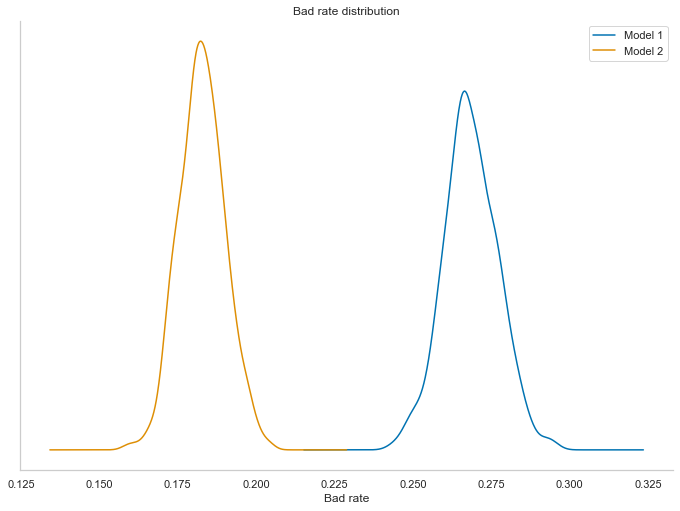

In [6]:
ax = pd.concat([bad_rates1, bad_rates2], axis=1).plot.kde()
ax.set(
    title="Bad rate distribution",
    xlabel="Bad rate",
)
ax.grid(False)
ax.get_yaxis().set_visible(False)
sns.despine()

## NPV
Jogamos esses valores na calculadora no Sheets para obter a distribuição de NPV para cada modelo

In [7]:
SIZE = 10_000

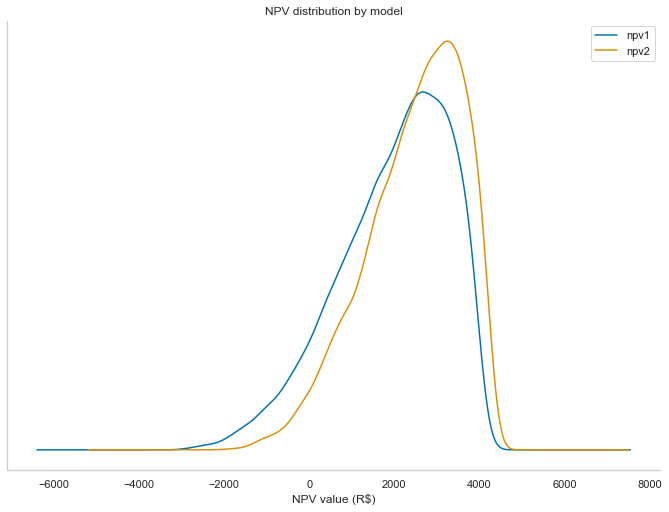

In [8]:
npv1 = PertRecord(-3_789.63, 2_931.11, 4_064.17)
npv2 = PertRecord(-2_493.63, 3_255.11, 4_326.61)

npv_dist1 = pd.Series(pert(*npv1, gen, size=SIZE), name="npv1")
npv_dist2 = pd.Series(pert(*npv2, gen, size=SIZE), name="npv2")

ax = pd.concat([npv_dist1, npv_dist2], axis=1).plot.kde()
ax.set(
    title="NPV distribution by model",
    xlabel="NPV value (R$)"
)
ax.grid(False)
ax.get_yaxis().set_visible(False)
sns.despine()

In [9]:
pd.DataFrame({
    "Model 1": {
        "KS": ks1,
        "Probability of loss": npv_dist1.lt(0).mean(),
        "Average NPV": (npv1.pessimist + 4 * npv1.base + npv1.optimist) / 6,
        "Risk": (npv1.optimist - npv1.pessimist) / 6,
    },
    "Model 2": {
        "KS": ks2,
        "Probability of loss": npv_dist2.lt(0).mean(),
        "Average NPV": (npv2.pessimist + 4 * npv2.base + npv2.optimist) / 6,
        "Risk": (npv2.optimist - npv2.pessimist) / 6,
    },
}).T.assign(**{
    "Benefit / Risk": lambda df: df["Average NPV"].div(df["Risk"])
}).style.format({
    "KS": "{:.0%}",
    "Probability of loss": "{:.0%}",
    "Average NPV": "{:,.0f}",
    "Risk": "{:,.0f}",
    "Benefit / Risk": "{:.2f}"
})

,KS,Probability of loss,Average NPV,Risk,Benefit / Risk
Model 1,20%,9%,"2,000","1,309",1.53
Model 2,35%,3%,"2,476","1,137",2.18
